In [1]:
import keras.utils as image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import random
import csv
import shutil
from sklearn.model_selection import train_test_split

2022-12-28 17:40:23.640709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
paths = {
    'MODEL_DIR': os.path.join('model'),
    'LOG_DIR' : os.path.join('model', 'log_dir'),
    'IMAGES_PATH': os.path.join('workspace','images','all'),
    'ANNOTATION_PATH': os.path.join('workspace','annotations.csv'),
    'RAW_DATA_PATH' : os.path.join('workspace', 'raw_data'),
    'RESULTS_PATH': os.path.join('workspace','results'),
    'TRANSFER_LEARNING_RESULTS': os.path.join('workspace','transfer_learning_results'),
    'TRAIN_PATH' : os.path.join('workspace', 'images', 'train'),
    'TEST_PATH' : os.path.join('workspace', 'images','test'),
    'EVAL_PATH' : os.path.join('workspace', 'images','eval'),
 }

/content/drive/MyDrive/ColabNotebooks/CNN/workspace/annotations.csv


In [44]:
# create paths
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix': # Unix-like
            !mkdir -p {path}
        if os.name == 'nt': # Windows
            !mkdir {path}



workspace/images/eval/workspace/annotations.csv


In [51]:
annotations = pd.read_csv(paths['ANNOTATION_PATH'])
number_per_class = annotations.groupby('Class').count()

labels = number_per_class.to_dict()['Path']
print(labels)

{0: 3461, 1: 6997, 2: 6292, 3: 349, 4: 1534, 5: 17, 6: 589, 7: 1121, 8: 906, 9: 519}


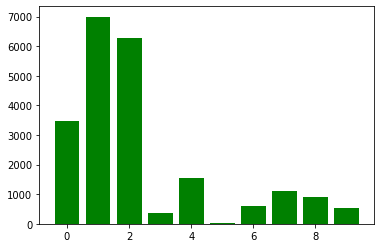

In [52]:
plt.bar(list(labels.keys()), labels.values(), color='g')
plt.show()


In [63]:
CLASSES_TO_AUGMENT = [0,3,4,6,7,8,9]
CLASSES_TO_REDUCE = [1,2]
CLASS_TO_DELETE = 5

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.1,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [54]:
def get_target_images(label):
  target = annotations[annotations['Class'] == label]
  return target

In [65]:
def remove_images(label):
    target = get_target_images(label) #get info about images whose class is 'label'
    img_names = list(target['Path']) #get images name
    for image in img_names:  # Go over each image name to be deleted
      f = os.path.join(paths['IMAGES_PATH'],image)  # Create valid path to image
      os.remove(f)  # Remove the image

In [72]:
def remove_annotation(label):
  target = annotations[annotations['Class'] != label]
    #update annotations
  target.to_csv('workspace/final_annotations.csv')
  paths['ANNOTATION_PATH'] = os.path.join('workspace/final_annotations.csv')
  annotations = pd.read_csv(paths['ANNOTATION_PATH'])
  

In [125]:
def undersample(label,n):
    img_names = os.listdir(os.path.join(paths['TRAIN_PATH'],str(label)))
    img_names = random.sample(img_names,n)  # Pick n random images to remove
    for image in img_names:  # Go over each image name to be deleted
      f = os.path.join(paths['TRAIN_PATH'],str(label),image)  # Create valid path to image
      os.remove(f)  # Remove the image

In [134]:
files_per_label = dict()

N_IMG_TO_DELETE = [2017,1551]
CLASSES_TO_REDUCE = [1,2]


for i in range(10):
  if i == 5:
    continue
  path = os.path.join(paths['TRAIN_PATH'],str(i))
  n_images = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
  files_per_label[i] = n_images

In [ ]:
print(files_per_label)
plt.bar(list(files_per_label.keys()), files_per_label.values(), color='g')
plt.show()

In [60]:
def save_annotation_to_csv(img_name,label):
      fields=[img_name,label]
      with open(paths['ANNOTATION_PATH'], 'a') as f:
          writer = csv.writer(f)
          writer.writerow(fields)

In [61]:
def augment_images(label,number_images):
    number_images = int(number_images)
    target = get_target_images(label)
    for _,row in target.iterrows():
      img = image.load_img('train/'+row['Path'], target_size=(256, 256)) 
      x = image.img_to_array(img)
      x = x.reshape((1,) + x.shape)
      i = 0
      for batch in datagen.flow(x, batch_size=1):
          plt.figure(i)
          plt.imshow(image.array_to_img(batch[0]))
          new_image = image.array_to_img(batch[0])
          new_image.save(os.path.join('workspace', 'images', 'train',label,"aug_" + i +".jpg"))
          save_annotation_to_csv("aug_"  +i +".jpg",label)
          i += 1
          if i > number_images:
              break

In [66]:
remove_images(CLASS_TO_DELETE)
remove_annotation(CLASS_TO_DELETE)

In [76]:
for i in range(0,10):
    if not os.path.exists(os.path.join(paths["EVAL_PATH"],str(i))):
        if os.name == 'posix':
            !mkdir -p {os.path.join(paths["EVAL_PATH"],str(i))}
    if not os.path.exists(os.path.join(paths["TRAIN_PATH"],str(i))):
        if os.name == 'posix':
            !mkdir -p {os.path.join(paths["TRAIN_PATH"],str(i))}
    if not os.path.exists(os.path.join(paths["TEST_PATH"],str(i))):
        if os.name == 'posix':
            !mkdir -p {os.path.join(paths["TEST_PATH"],str(i))}

X_train, X_test, y_train, y_test = train_test_split(annotations, annotations, test_size=0.1, shuffle=True,stratify=annotations['Class'])
for index, row in X_test.iterrows():
    shutil.copy(os.path.join(paths["IMAGES_PATH"],str(row['Path'])),
                os.path.join(paths["TEST_PATH"],str(row['Class']),str(row['Path'])))

# split the training set into the final training set (80%) and validation set (20%)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
print("Test size: " + str(len(X_test)))
print("Eval size: " + str(len(X_eval)))

for index, row in X_train.iterrows():
    shutil.copy(os.path.join(paths["IMAGES_PATH"],str(row['Path'])),
                os.path.join(paths["TRAIN_PATH"],str(row['Class']),str(row['Path'])))

for _, row in X_eval.iterrows():
    shutil.copy(os.path.join(paths["IMAGES_PATH"],str(row['Path'])),
                os.path.join(paths["EVAL_PATH"],str(row['Class']),str(row['Path'])))

Test size: 2177
Eval size: 3919


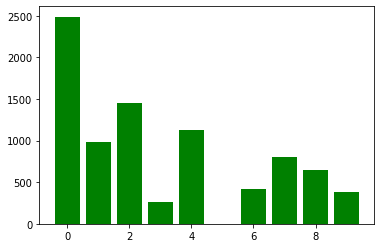

In [140]:

files_per_label = dict()

for i in range(10):
  if i == 5:
    continue
  path = os.path.join(paths['TRAIN_PATH'],str(i))
  n_images = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
  files_per_label[i] = n_images

plt.bar(list(files_per_label.keys()), files_per_label.values(), color='g')
plt.show()

In [138]:
print(files_per_label)

{0: 2488, 1: 983, 2: 1449, 3: 257, 4: 1122, 6: 415, 7: 797, 8: 645, 9: 380}


In [2]:
# sort
# prendi massimo
# prendi minimo
# se minimo < massimo / 2
# rebalance

# rebalance
# nuovo_massimo -> 3/4 * massimo
for key, value in files_per_label.items():
    # tutte le altre ->
    # se |dim - nuovomassimo| > threshold -> riduci o aumenta in funzione del segno di dim - nuovomax
    # threshold = nuovomassimo / 5
    # se dim - nuovomax > 0 riduzione di dim - nuovomax + rand(0,50)
    # se dim < nuovomax / 5 aumenta di 2*dim
    # se dim - nuovomax < 0 aumenta di nuovomax - dim + rand(0,50)

IndentationError: expected an indented block (3846724067.py, line 1)

In [139]:
for i in range(10):
  if i != 1:
    continue

  train_label_path = os.path.join(paths['TRAIN_PATH'],str(i))  
  if not os.path.exists(os.path.join(train_label_path)):
    if os.name == 'posix':
      !mkdir -p {os.path.join(drive_path,train_label_path)}

  for f in os.listdir(train_label_path):
    shutil.copy(os.path.join(train_label_path,f),
                os.path.join(train_label_path,f))   
